In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error as mse
from regression import Regression
from feature_selection import FeatureSelection
from datetime import datetime
from predict import Predict
from pca_mds import Reduction
from cross_validation import CrossValidation
from CNN_for_Regression import DoCNN
import warnings as wrn
%load_ext autoreload
%autoreload 2
np.set_printoptions(linewidth=100)
wrn.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Always display all the columns
pd.set_option('max_columns', None)
pd.set_option('display.width', 1000)
# pd.set_option('display.max_columns', 60)


def NRMSE(y_actual, y_predicted):
    N = len(y_actual)

    return np.sqrt(1 / N * np.sum(y_actual - y_predicted) ** 2) / (np.max(y_actual) - np.min(y_actual))


df = pd.read_csv('state_county_info_cleaned.csv', index_col='date', parse_dates=['date'])

allow_date = df.index[df.index > '4/30/2020'].values    # Start from May 1, 2020

date = allow_date[np.random.randint(1, len(allow_date))]
printable_date = pd.to_datetime(str(date)).strftime('%m/%d/%Y')
print('Date selected: ', printable_date)

data = df[df.index == date].drop(['serial', 'cases', 'deaths', 'state', 'county', 'total_population', 'cases_population_proportion', 'deaths_population_proportion'], axis=1)
target = df[df.index == date]['cases']

X = data.values
y = target.values

Errors = []
Models = ['Linear Regression on full set', 'Ridge Regression on full set', 'Lasso Regression on full set', 'Linear Regression on reduced set (Backward Eliminination)', 'Ridge Regression on reduced set (Backward Eliminination)', 'Linear Regression on reduced set (Forward Selection)', 'Ridge Regression on reduced set (Forward Selection)', 'Linear Regression on reduced set (PCA)', 'Ridge Regression on reduced set (PCA)', 'Linear Regression on reduced set (MDS)', 'Ridge Regression on reduced set (MDS)', 'CNN Regression on full set', 'CNN Regression on reduced set (Backward Elimination)', 'CNN Regression on reduced set (Forward Selection)', 'CNN Regression on reduced set (PCA)', 'CNN Regression on reduced set (MDS)']


Date selected:  07/16/2020


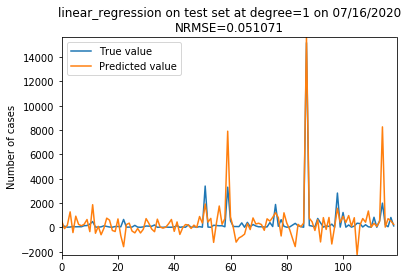

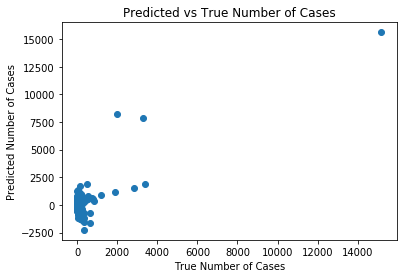

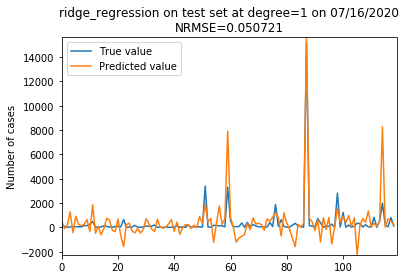

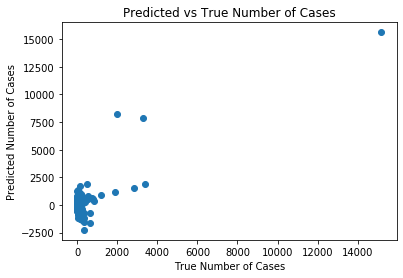

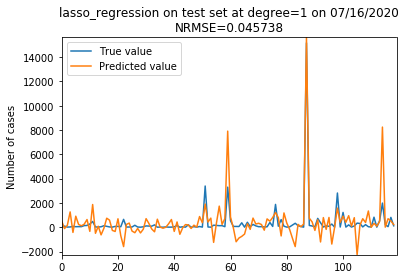

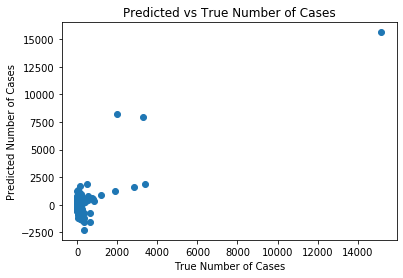

In [10]:
models = ['linear_regression', 'ridge_regression', 'lasso_regression']
for model in models:
    pass1 = Predict(model, X, y)
    use_degree = pass1.degree_optimum()
    predict_y = pass1.prediction(use_degree)

    error = NRMSE(pass1.test_y, predict_y)
    Errors.append(error)

    # plt.subplot(321)
    plt.plot(np.arange(len(pass1.test_y)), pass1.test_y, label='True value')
    plt.plot(np.arange(len(pass1.test_y)), predict_y, label='Predicted value')
    plt.legend()
    plt.xlim(0, len(pass1.test_y))
    plt.ylim(np.min([pass1.test_y, predict_y]), np.max([pass1.test_y, predict_y]))
    plt.title('%s on test set at degree=%d on %s\nNRMSE=%f' % (model, use_degree, printable_date, error))
    plt.ylabel('Number of cases')
    
#     temp_state_county = df[df.index == date][['state', 'county']].values[::-1][:len(pass1.test_y)][::-1].tolist()
#     state_county = []
#     for i in temp_state_county:
#         state_county.append([' - '.join(i)])
#     state_county = sum(state_county, [])
#     plt.xticks(np.arange(len(pass1.test_y)), state_county, rotation='vertical')
#     plt.figure(figsize=(12, 9))
    plt.show()
    
    plt.scatter(pass1.test_y, predict_y)
    plt.xlabel('True Number of Cases')
    plt.ylabel('Predicted Number of Cases')
    plt.title('Predicted vs True Number of Cases')
    plt.show()


In [11]:
feat = FeatureSelection()
forward, X_forward = feat.forward_selection(data, target, significance_level=0.05)
backward, X_backward = feat.backward_elimination(data, target, significance_level=0.05)
print('\nFeatures selected from Forward Selection:\n', forward)
print('\nFeatures selected from Backward Elimination:\n', backward)
# print('\n', data.columns)
# print('\n')
# print(len(forward))
# print(len(backward))
# print(X.shape[1])


Features selected from Forward Selection:
 ['num_primary_care_physicians', 'percent_asian', 'population_density_per_sqmi', 'percent_native_hawaiian_other_pacific_islander', 'percent_not_proficient_in_english', 'other_primary_care_provider_rate', 'per_capita_income', 'date_stay_at_home_effective', 'median_household_income', 'percent_rural', 'life_expectancy', 'percent_adults_with_obesity', 'percent_65_and_over', 'percent_less_than_18_years_of_age']

Features selected from Backward Elimination:
 ['percent_smokers', 'percent_uninsured', 'income_ratio', 'percent_uninsured_2', 'other_primary_care_provider_rate', 'median_household_income', 'percent_less_than_18_years_of_age', 'percent_american_indian_alaska_native', 'percent_asian', 'percent_non_hispanic_white', 'percent_female', 'percent_rural', 'percent_overcrowding', 'date_stay_at_home_effective']


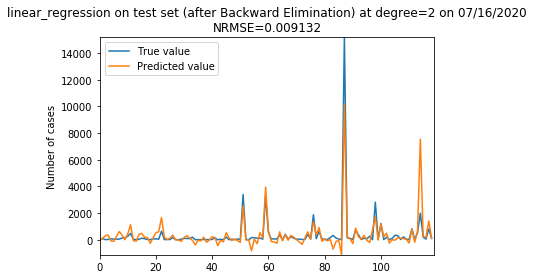

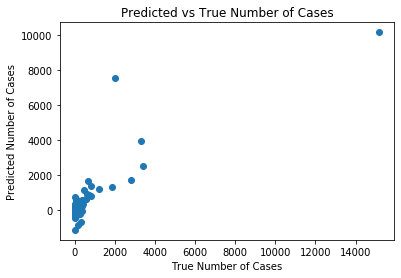

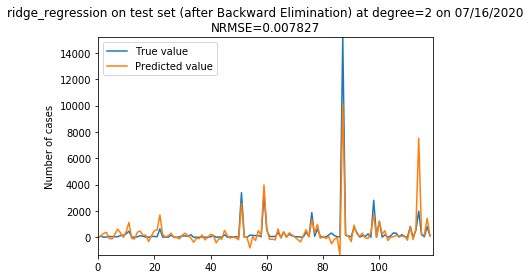

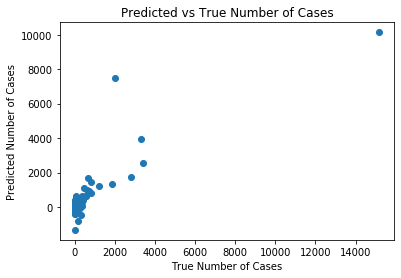

In [12]:
# Backward Elimination

models = ['linear_regression', 'ridge_regression']
for model in models:
    pass2 = Predict(model, X_backward, y)
    use_degree = pass2.degree_optimum()
    predict_y = pass2.prediction(use_degree)

    error = NRMSE(pass2.test_y, predict_y)
    Errors.append(error)

#     plt.subplot(211)
    plt.plot(np.arange(len(pass2.test_y)), pass2.test_y, label='True value')
    plt.plot(np.arange(len(pass2.test_y)), predict_y, label='Predicted value')
    plt.legend()
    plt.xlim(0, len(pass2.test_y))
    plt.ylim(np.min([pass2.test_y, predict_y]), np.max([pass2.test_y, predict_y]))
    plt.title('%s on test set (after Backward Elimination) at degree=%d on %s\nNRMSE=%f' % (model, use_degree, printable_date, error))
    plt.ylabel('Number of cases')
    plt.show()
    
    plt.scatter(pass2.test_y, predict_y)
    plt.xlabel('True Number of Cases')
    plt.ylabel('Predicted Number of Cases')
    plt.title('Predicted vs True Number of Cases')
    plt.show()

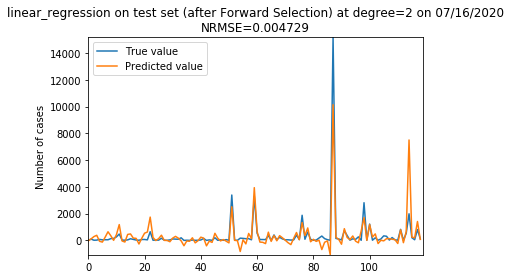

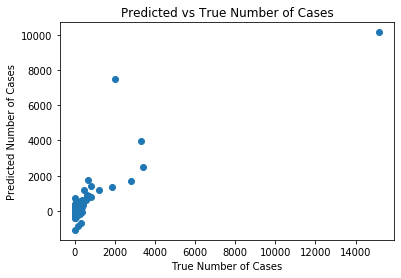

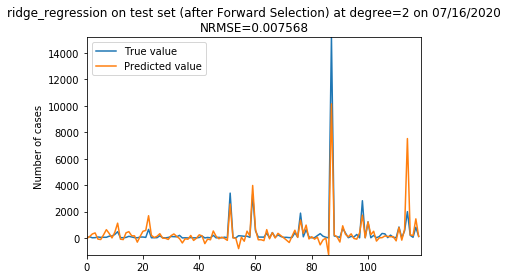

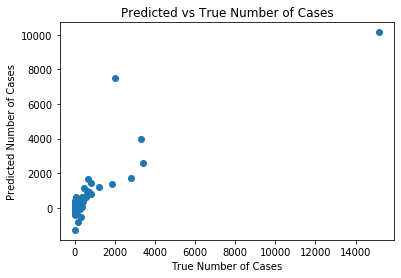

In [13]:
# Forward Selection

models = ['linear_regression', 'ridge_regression']
for model in models:
    pass3 = Predict(model, X_forward, y)
    use_degree = pass3.degree_optimum()
    predict_y = pass3.prediction(use_degree)

    error = NRMSE(pass3.test_y, predict_y)
    Errors.append(error)

    # plt.subplot(321)
    plt.plot(np.arange(len(pass3.test_y)), pass3.test_y, label='True value')
    plt.plot(np.arange(len(pass3.test_y)), predict_y, label='Predicted value')
    plt.legend()
    plt.xlim(0, len(pass3.test_y))
    plt.ylim(np.min([pass3.test_y, predict_y]), np.max([pass3.test_y, predict_y]))
    plt.title('%s on test set (after Forward Selection) at degree=%d on %s\nNRMSE=%f' % (model, use_degree, printable_date, error))
    plt.ylabel('Number of cases')
    plt.show()
    
    plt.scatter(pass3.test_y, predict_y)
    plt.xlabel('True Number of Cases')
    plt.ylabel('Predicted Number of Cases')
    plt.title('Predicted vs True Number of Cases')
    plt.show()

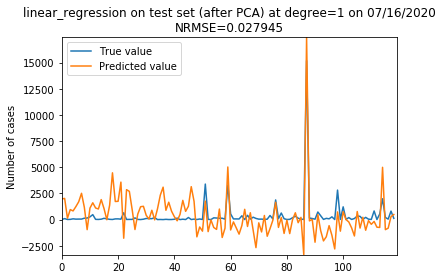

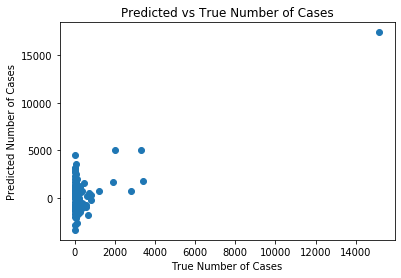

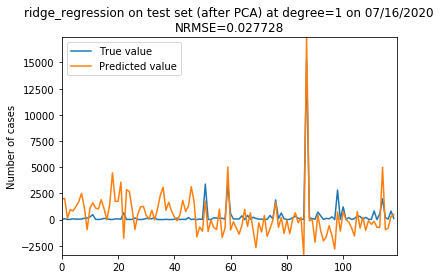

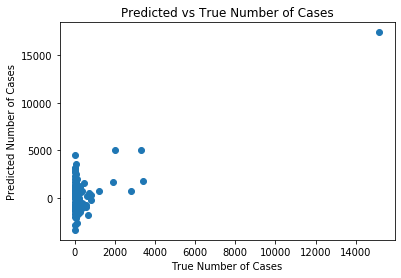

In [14]:
# PCA

reduce = Reduction(X)
X_PCA, num_features = reduce.pca(0.9)

models = ['linear_regression', 'ridge_regression']
for model in models:
    pass4 = Predict(model, X_PCA, y)
    use_degree = pass4.degree_optimum()
    predict_y = pass4.prediction(use_degree)

    error = NRMSE(pass4.test_y, predict_y)
    Errors.append(error)

    # plt.subplot(321)
    plt.plot(np.arange(len(pass4.test_y)), pass4.test_y, label='True value')
    plt.plot(np.arange(len(pass4.test_y)), predict_y, label='Predicted value')
    plt.legend()
    plt.xlim(0, len(pass4.test_y))
    plt.ylim(np.min([pass4.test_y, predict_y]), np.max([pass4.test_y, predict_y]))
    plt.title('%s on test set (after PCA) at degree=%d on %s\nNRMSE=%f' % (model, use_degree, printable_date, error))
    plt.ylabel('Number of cases')
    plt.show()
    
    plt.scatter(pass4.test_y, predict_y)
    plt.xlabel('True Number of Cases')
    plt.ylabel('Predicted Number of Cases')
    plt.title('Predicted vs True Number of Cases')
    plt.show()

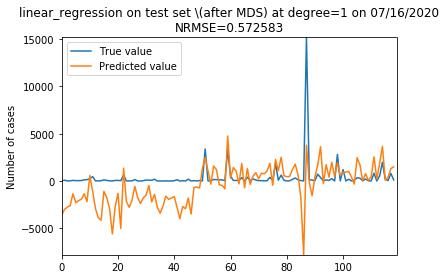

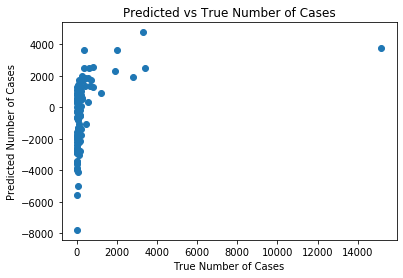

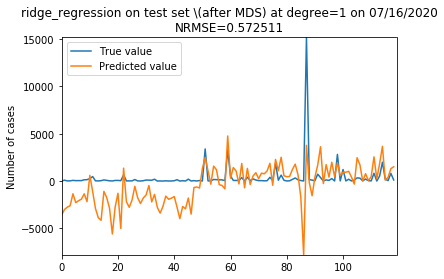

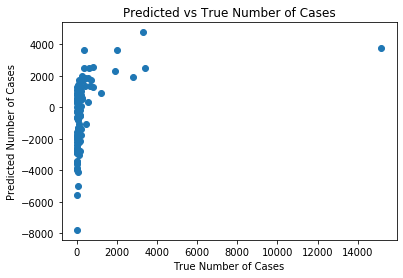

In [15]:
# MDS

MDS_components = 4
reduce = Reduction(X)
X_MDS = reduce.mds(4)
models = ['linear_regression', 'ridge_regression']
for model in models:
    pass9 = Predict(model, X_MDS, y)
    use_degree = pass9.degree_optimum()
    predict_y = pass9.prediction(use_degree)

    error = NRMSE(pass9.test_y, predict_y)
    Errors.append(error)

    # plt.subplot(321)
    plt.plot(np.arange(len(pass9.test_y)), pass9.test_y, label='True value')
    plt.plot(np.arange(len(pass9.test_y)), predict_y, label='Predicted value')
    plt.legend()
    plt.xlim(0, len(pass9.test_y))
    plt.ylim(np.min([pass9.test_y, predict_y]), np.max([pass9.test_y, predict_y]))
    plt.title('%s on test set (after MDS) at degree=%d on %s\nNRMSE=%f' % (model, use_degree, printable_date, error))
    plt.ylabel('Number of cases')
    plt.show()
    
    plt.scatter(pass9.test_y, predict_y)
    plt.xlabel('True Number of Cases')
    plt.ylabel('Predicted Number of Cases')
    plt.title('Predicted vs True Number of Cases')
    plt.show()

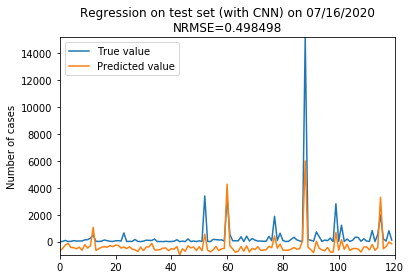

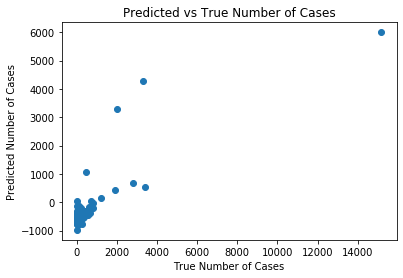

In [16]:
# CNN

pass5 = DoCNN(X, y, 0.05)
predict_y = pass5.predict()
error = NRMSE(pass5.test_y, predict_y)
Errors.append(error)

# plt.subplot(324)
plt.plot(np.arange(len(pass5.test_y)), pass5.test_y, label='True value')
plt.plot(np.arange(len(pass5.test_y)), predict_y, label='Predicted value')
plt.legend()
plt.xlim(0, len(pass5.test_y))
plt.ylim(np.min([pass5.test_y, predict_y]), np.max([pass5.test_y, predict_y]))
plt.title('Regression on test set (with CNN) on %s\nNRMSE=%f' % (printable_date, error))
plt.ylabel('Number of cases')
plt.show()

plt.scatter(pass5.test_y, predict_y)
plt.xlabel('True Number of Cases')
plt.ylabel('Predicted Number of Cases')
plt.title('Predicted vs True Number of Cases')
plt.show()

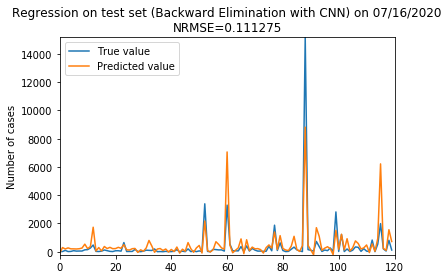

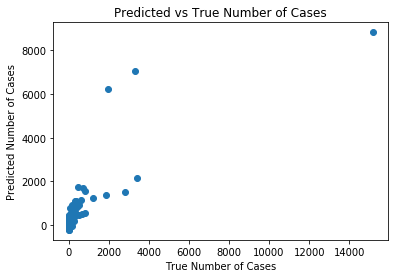

In [17]:
# CNN plus Backward Elimination

pass6 = DoCNN(X_backward, y, 0.05)
predict_y = pass6.predict()
error = NRMSE(pass6.test_y, predict_y)
Errors.append(error)

# plt.subplot(324)
plt.plot(np.arange(len(pass6.test_y)), pass6.test_y, label='True value')
plt.plot(np.arange(len(pass6.test_y)), predict_y, label='Predicted value')
plt.legend()
plt.xlim(0, len(pass6.test_y))
plt.ylim(np.min([pass6.test_y, predict_y]), np.max([pass6.test_y, predict_y]))
plt.title('Regression on test set (Backward Elimination with CNN) on %s\nNRMSE=%f' % (printable_date, error))
plt.ylabel('Number of cases')
plt.show()

plt.scatter(pass6.test_y, predict_y)
plt.xlabel('True Number of Cases')
plt.ylabel('Predicted Number of Cases')
plt.title('Predicted vs True Number of Cases')
plt.show()

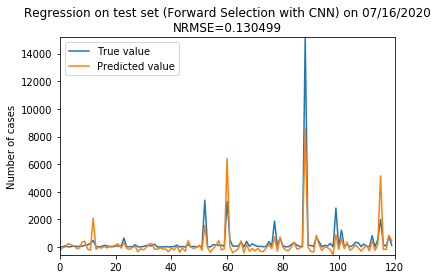

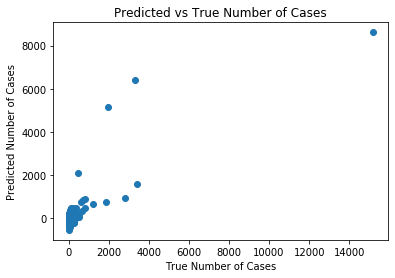

In [18]:
# CNN plus Forward Selection

pass7 = DoCNN(X_forward, y, 0.05)
predict_y = pass7.predict()
error = NRMSE(pass7.test_y, predict_y)
Errors.append(error)

# plt.subplot(324)
plt.plot(np.arange(len(pass7.test_y)), pass7.test_y, label='True value')
plt.plot(np.arange(len(pass7.test_y)), predict_y, label='Predicted value')
plt.legend()
plt.xlim(0, len(pass7.test_y))
plt.ylim(np.min([pass7.test_y, predict_y]), np.max([pass7.test_y, predict_y]))
plt.title('Regression on test set (Forward Selection with CNN) on %s\nNRMSE=%f' % (printable_date, error))
plt.ylabel('Number of cases')
plt.show()

plt.scatter(pass7.test_y, predict_y)
plt.xlabel('True Number of Cases')
plt.ylabel('Predicted Number of Cases')
plt.title('Predicted vs True Number of Cases')
plt.show()

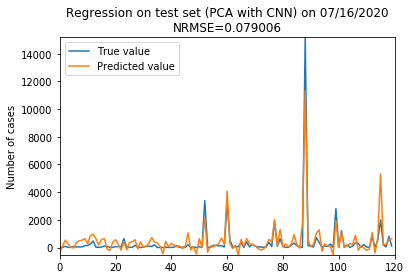

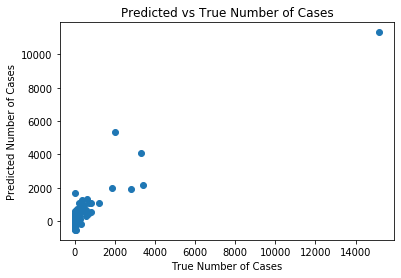

In [19]:
# CNN plus PCA

pass8 = DoCNN(X_PCA, y, 0.05)
predict_y = pass8.predict()
error = NRMSE(pass8.test_y, predict_y)
Errors.append(error)

# plt.subplot(324)
plt.plot(np.arange(len(pass8.test_y)), pass8.test_y, label='True value')
plt.plot(np.arange(len(pass8.test_y)), predict_y, label='Predicted value')
plt.legend()
plt.xlim(0, len(pass8.test_y))
plt.ylim(np.min([pass8.test_y, predict_y]), np.max([pass8.test_y, predict_y]))
plt.title('Regression on test set (PCA with CNN) on %s\nNRMSE=%f' % (printable_date, error))
plt.ylabel('Number of cases')
plt.show()

plt.scatter(pass8.test_y, predict_y)
plt.xlabel('True Number of Cases')
plt.ylabel('Predicted Number of Cases')
plt.title('Predicted vs True Number of Cases')
plt.show()

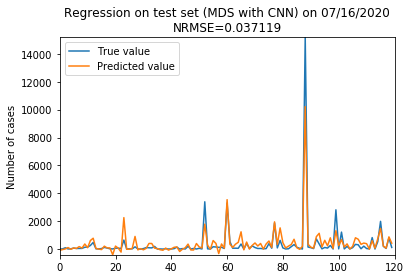

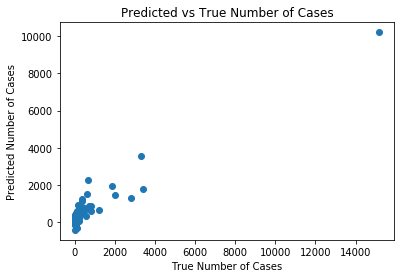

In [20]:
# CNN plus MDS

pass10 = DoCNN(X_MDS, y, 0.05)
predict_y = pass10.predict()
error = NRMSE(pass10.test_y, predict_y)
Errors.append(error)

# plt.subplot(324)
plt.plot(np.arange(len(pass10.test_y)), pass10.test_y, label='True value')
plt.plot(np.arange(len(pass10.test_y)), predict_y, label='Predicted value')
plt.legend()
plt.xlim(0, len(pass10.test_y))
plt.ylim(np.min([pass10.test_y, predict_y]), np.max([pass10.test_y, predict_y]))
plt.title('Regression on test set (MDS with CNN) on %s\nNRMSE=%f' % (printable_date, error))
plt.ylabel('Number of cases')
plt.show()

plt.scatter(pass10.test_y, predict_y)
plt.xlabel('True Number of Cases')
plt.ylabel('Predicted Number of Cases')
plt.title('Predicted vs True Number of Cases')
plt.show()

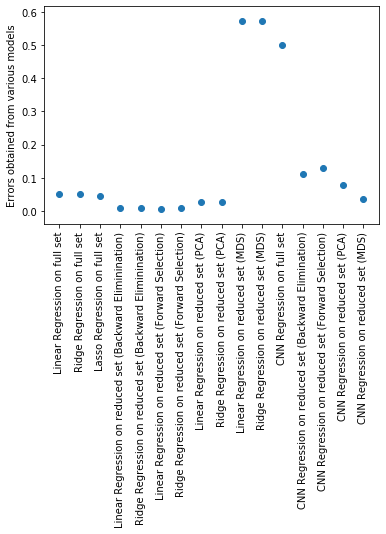

In [21]:
plt.scatter(np.arange(len(Errors)), Errors)
plt.xticks(np.arange(len(Errors)), Models, rotation='vertical')
plt.ylabel('Errors obtained from various models')
plt.show()